In [1]:
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import fft
from scipy import signal as sig
from sklearn.linear_model import LinearRegression
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
def pickle_file(obj, path):
    file = open(path, 'wb')
    pickle.dump(obj, file)
    file.close()

def load_pickle(path):
    file = open(path, 'rb')
    obj = pickle.load(file)
    file.close()
    return obj

In [204]:
# df = load_pickle('../data_merged/mta_station_broughs_cases')
df.columns

Index(['DATE', 'STATION', 'LINENAME', 'DAILY_ENTRIES', 'DAILY_EXITS',
       'LINE_DENSITY', 'ZIP_CODE', 'BOROUGH', 'CASE_COUNT',
       'HOSPITALIZED_COUNT', 'DEATH_COUNT', 'CASE_COUNT_7DAY_AVG'],
      dtype='object')

In [218]:
def pickle_file(obj, path):
    file = open(path, 'wb')
    pickle.dump(obj, file)
    file.close()

def load_pickle(path):
    file = open(path, 'rb')
    obj = pickle.load(file)
    file.close()
    return obj
df = load_pickle('../data_merged/mta_station_broughs_cases')
# df = df.groupby('DATE','STATION', 'ZIP_CODE', 'LINENAME').sum().reset_index()
df['WEEK_YEAR']= pd.to_datetime(df["DATE"].dt.strftime('%Y-%m'))
# df = df[(df.DATE >= '2020-04-01') & (df.DATE <= '2022-01-01')]
# df = df[df.DATE >= '2020-04-01']
# df['HOURS_ELAPSE'] = (df.DATE - pd.to_datetime('2020-04-01')).astype('timedelta64[h]')
df['HOURS_ELAPSE'] = (df.DATE - df.DATE.min()).astype('timedelta64[h]')
df['lockdown_active'] = (df.DATE >= '2020-03-14') & (df.DATE <= '2020-06-08')
df['lockdown_active'] = df['lockdown_active']*1
df['post_lockdown'] = (df.DATE - pd.to_datetime('2020-06-08')).astype('timedelta64[h]')
df['post_lockdown'] = (df['post_lockdown'] * (df.DATE >= '2020-06-08')) + ((df.DATE <= '2020-03-14') *10**6)
df['post_lockdown'] = 1/(1+np.exp(-.0003*(df.post_lockdown-18000)))


df['zip_code'] = df.ZIP_CODE.astype(str)
df['hospitalizations'] = df['CASE_COUNT_7DAY_AVG']
df['borough'] = df.BOROUGH
# df['time_elapsed'] = (df.DATE - pd.to_datetime('2020-04-01')).astype('timedelta64[h]')
df['time_elapsed'] = (df.DATE - df.DATE.min()).astype('timedelta64[h]')
df['target'] = df.DAILY_EXITS + df.DAILY_ENTRIES
df['station'] = df.STATION
df['lines'] = df.LINENAME
df = df.groupby('time_elapsed').agg({'hospitalizations': 'max', 'target': 'sum',
                    'lockdown_active':'max', 'post_lockdown':'max', 'hospitalizations':'max', 'DATE':'max' }).reset_index()
df.head()

,time_elapsed,hospitalizations,target,lockdown_active,post_lockdown,DATE
0,0.0,0.0,5.169702e+06,0,1.0,2017-12-30
1,24.0,0.0,4.449544e+06,0,1.0,2017-12-31
2,48.0,0.0,3.477932e+06,0,1.0,2018-01-01
3,72.0,0.0,8.873302e+06,0,1.0,2018-01-02
4,96.0,0.0,9.686037e+06,0,1.0,2018-01-03


In [176]:
df = df[df.DATE <= '2021-03-01']
# df['HOURS_ELAPSE'] = (df.DATE - pd.to_datetime('2020-04-01')).astype('timedelta64[h]')
# df.head()

In [219]:
df = df.groupby('time_elapsed').agg({'hospitalizations': 'max', 'target': 'sum',
                    'lockdown_active':'max', 'post_lockdown':'max', 'hospitalizations':'max', 'DATE':'max' }).reset_index()
X1 = pd.DataFrame(df[['time_elapsed','lockdown_active', 'post_lockdown', 'hospitalizations']]) 
# signal is how many calls were made in that hour
y = pd.DataFrame(df.target) 

model1 = LinearRegression(positive=True)
model1.fit(X1, y) 
df['pred_exits_linreg_date'] = model1.predict(X1)
df['residuals'] = df.target - df.pred_exits_linreg_date


# time = data['time']
# residuals = data['residuals']
print('Slope: {:.2e}, Intercept: {:.2f}'.format(model1.coef_[0,0], model1.intercept_[0]))
print('R-squared: {:.2e}'.format(model1.score(X1,y)))
# model1.score(X1,y)

Slope: 3.77e+01, Intercept: 1516899.94
R-squared: 6.74e-01


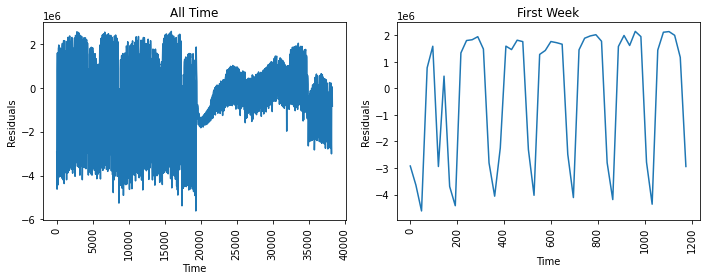

In [220]:
## Plot residuals in the time domain
plt.figure(figsize=(10, 4))

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(df.time_elapsed, df.residuals, label='residuals')
ax1.set_title('All Time')
ax1.set_ylabel( 'Residuals' )
ax1.set_xlabel( 'Time' )
plt.xticks(rotation=90)

N = 50

ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(df.time_elapsed[:N], df.residuals[:N])
ax2.set_title('First Week')
ax2.set_ylabel( 'Residuals' )
ax2.set_xlabel( 'Time' )

plt.tight_layout()
plt.xticks(rotation=90)

plt.show()

In [93]:
df[df.residuals > 4000000]

,time_elapsed,hospitalizations,target,lockdown_active,post_lockdown,DATE,pred_exits_linreg_date,residuals
793,19032.0,2.0,9.754825e+06,0,0.010987,2020-03-02,2.362005e+06,7.392820e+06
794,19056.0,7.0,1.005596e+07,0,0.010987,2020-03-03,2.362005e+06,7.693959e+06
795,19080.0,2.0,1.007072e+07,0,0.010987,2020-03-04,2.362005e+06,7.708713e+06
796,19104.0,14.0,1.005714e+07,0,0.010987,2020-03-05,2.362005e+06,7.695134e+06
797,19128.0,8.0,9.636331e+06,0,0.010987,2020-03-06,2.362005e+06,7.274325e+06
800,19200.0,37.0,9.145538e+06,0,0.010987,2020-03-09,2.362005e+06,6.783532e+06
801,19224.0,60.0,8.969252e+06,0,0.010987,2020-03-10,2.362005e+06,6.607247e+06
802,19248.0,79.0,8.649355e+06,0,0.010987,2020-03-11,2.362005e+06,6.287350e+06
803,19272.0,105.0,7.666984e+06,0,0.010987,2020-03-12,2.362005e+06,5.304979e+06
804,19296.0,151.0,6.491147e+06,0,0.010987,2020-03-13,2.362005e+06,4.129141e+06


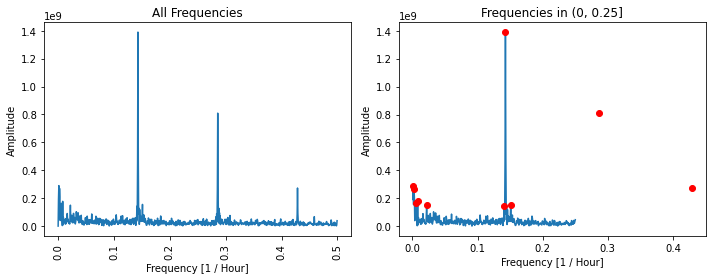

In [235]:
time = df.time_elapsed
residuals = np.array(df.residuals)

# Plotting power in the frequency domain
fft_output = fft.fft(residuals)
power = np.abs(fft_output)
freq = fft.fftfreq(len(residuals))

mask = freq >= 0
freq = freq[mask]
power = power[mask]

plt.figure( figsize=(10, 4) )

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(freq, power, label='residuals')
ax1.set_title('All Frequencies')
ax1.set_ylabel( 'Amplitude' )
ax1.set_xlabel( 'Frequency [1 / Hour]' )
plt.xticks(rotation=90)

ax2 = plt.subplot( 1, 2, 2 )
mask = (freq > 0) & (freq <= 0.25)
ax2.plot(freq[mask], power[mask])
ax2.set_title('Frequencies in (0, 0.25]')
ax2.set_ylabel( 'Amplitude' )
ax2.set_xlabel( 'Frequency [1 / Hour]' )

peaks = sig.find_peaks(power[freq >=0], prominence=10**7.98)[0]
peak_freq =  freq[peaks]
peak_power = power[peaks]
plt.plot(peak_freq, peak_power, 'ro')

plt.tight_layout()

In [236]:
output = pd.DataFrame()
output['index'] = peaks
output['freq (1/hour)'] = peak_freq
output['amplitude'] = peak_power
output['period (days)'] = 1 / peak_freq 
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)
output

,index,freq (1/hour),amplitude,period (days),fft
6,228,0.142857,1.390378e+09,7.000000,-1.158979e+09+7.680607e+08j
8,456,0.285714,8.094699e+08,3.500000,-3.448328e+08+7.323468e+08j
0,2,0.001253,2.901874e+08,798.000000,-2.777856e+08+8.392800e+07j
9,684,0.428571,2.728863e+08,2.333333,5.743786e+07+2.667729e+08j
1,4,0.002506,2.701373e+08,399.000000,-2.564553e+08-8.488120e+07j
3,13,0.008145,1.775585e+08,122.769231,-1.528654e+08-9.032820e+07j
2,9,0.005639,1.636011e+08,177.333333,-4.334717e+07+1.577540e+08j
7,241,0.151003,1.554519e+08,6.622407,1.415391e+08+6.428029e+07j
4,35,0.021930,1.499018e+08,45.600000,-8.325575e+07+1.246556e+08j
5,225,0.140977,1.424935e+08,7.093333,-9.977841e+07-1.017284e+08j


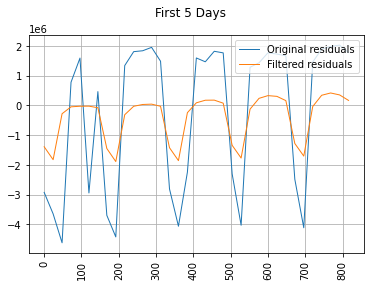

In [237]:
filtered_fft_output = np.array([f if i in list(output['index']) else 0 for i, f in enumerate(fft_output)])
filtered_residuals = fft.ifft(filtered_fft_output)

N = 35
plt.plot(time[:N], residuals[:N], linewidth=1, label='Original residuals')
plt.plot(time[:N], filtered_residuals[:N].real, linewidth=1, label='Filtered residuals')
plt.legend(loc='upper right')
plt.suptitle('First 5 Days')
plt.grid()
# plt.ylim((-25, 25))
plt.xticks(rotation=90)

print()

In [238]:
from cmath import phase

fourier_terms = pd.DataFrame()
fourier_terms['fft'] = output['fft']
fourier_terms['freq (1 / hour)'] = output['freq (1/hour)']
fourier_terms['amplitude'] = fourier_terms.fft.apply(lambda z: abs(z)) 
fourier_terms['phase'] = fourier_terms.fft.apply(lambda z: phase(z))
fourier_terms.sort_values(by=['amplitude'], ascending=[0])

# Create some helpful labels (FT_1..FT_N)
fourier_terms['label'] = list(map(lambda n : 'FT_{}'.format(n), range(1, len(fourier_terms) + 1)))

# Turn our dataframe into a dictionary for easy lookup
fourier_terms = fourier_terms.set_index('label')
fourier_terms_dict = fourier_terms.to_dict('index')

fourier_terms

,fft,freq (1 / hour),amplitude,phase
label,,,,
FT_1,-1.158979e+09+7.680607e+08j,0.142857,1.390378e+09,2.556338
FT_2,-3.448328e+08+7.323468e+08j,0.285714,8.094699e+08,2.010861
FT_3,-2.777856e+08+8.392800e+07j,0.001253,2.901874e+08,2.848181
FT_4,5.743786e+07+2.667729e+08j,0.428571,2.728863e+08,1.358728
FT_5,-2.564553e+08-8.488120e+07j,0.002506,2.701373e+08,-2.821963
FT_6,-1.528654e+08-9.032820e+07j,0.008145,1.775585e+08,-2.607891
FT_7,-4.334717e+07+1.577540e+08j,0.005639,1.636011e+08,1.838955
FT_8,1.415391e+08+6.428029e+07j,0.151003,1.554519e+08,0.426301
FT_9,-8.325575e+07+1.246556e+08j,0.021930,1.499018e+08,2.159643


In [239]:
def ft_function(df):
    data = df
    for key in fourier_terms_dict.keys():
        a = fourier_terms_dict[key]['amplitude']
        w = 2 * math.pi * (fourier_terms_dict[key]['freq (1 / hour)'] / 24)
        p = fourier_terms_dict[key]['phase']
        data[key] = data.time_elapsed.apply(lambda t: a * math.cos(w*t + p))

    data['FT_All'] = 0
    for column in list(fourier_terms.index):
        data['FT_All'] = data['FT_All'] + data[column]


    # Sample 
    # data[['DAILY_EXITS', 'HOURS_ELAPSE', 'FT_All']  + list(fourier_terms.index)]
    return data

data = ft_function(df)
data

,time_elapsed,hospitalizations,target,lockdown_active,post_lockdown,DATE,pred_exits_linreg_date,residuals,FT_1,FT_2,...,FT_6,FT_7,FT_8,FT_9,FT_All,y_pred,FT_10,FT_11,FT_12,FT_13
0,0.0,0.0,5.169702e+06,0,1.000000,2017-12-30,8.093608e+06,-2.923906e+06,-1.158979e+09,-3.448328e+08,...,-1.528654e+08,-4.334717e+07,1.415391e+08,-8.325575e+07,-2.218323e+09,4.608017e+06,-9.977841e+07,-9.977841e+07,8.239066e+07,4.466509e+06
1,24.0,0.0,4.449544e+06,0,1.000000,2017-12-31,8.094513e+06,-3.644969e+06,-1.323106e+09,-6.372528e+08,...,-1.480444e+08,-4.890826e+07,3.023089e+07,-9.958856e+07,-2.912040e+09,3.611765e+06,1.565207e+07,1.565207e+07,-1.832330e+07,2.534790e+07
2,48.0,0.0,3.477932e+06,0,1.000000,2018-01-01,8.095419e+06,-4.617487e+06,-4.909067e+08,6.284370e+08,...,-1.428357e+08,-5.440795e+07,-1.063094e+08,-1.140336e+08,-4.488169e+08,7.159588e+06,1.195839e+08,1.195839e+08,-1.046711e+08,4.517070e+07
3,72.0,0.0,8.873302e+06,0,1.000000,2018-01-02,8.096324e+06,7.769781e+05,7.109552e+08,3.575720e+08,...,-1.372529e+08,-5.983935e+07,-1.541191e+08,-1.263170e+08,-7.805317e+07,7.855278e+06,1.356646e+08,1.356646e+08,-1.089526e+08,6.310708e+07
4,96.0,0.0,9.686037e+06,0,1.000000,2018-01-03,8.097229e+06,1.588808e+06,1.377453e+09,-7.875715e+08,...,-1.313107e+08,-6.519563e+07,-7.329414e+07,-1.362060e+08,-4.763510e+07,8.097505e+06,5.208064e+07,5.208064e+07,-2.781100e+07,7.840797e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591,38184.0,0.0,5.244999e+06,0,0.410960,2022-05-09,5.660153e+06,-4.151538e+05,-4.909067e+08,6.284370e+08,...,-1.707507e+08,-1.486738e+07,-5.979142e+07,1.498004e+07,-2.595457e+08,5.764094e+06,1.255742e+08,1.255742e+08,-9.583958e+07,-8.578638e+07
1592,38208.0,0.0,5.671468e+06,0,0.412704,2022-05-10,5.672528e+06,-1.060441e+03,7.109552e+08,3.575720e+08,...,-1.680361e+08,-2.062949e+07,-1.514564e+08,-5.648416e+06,4.519864e+07,6.098234e+06,1.316021e+08,1.316021e+08,-1.145683e+08,-7.230624e+07
1593,38232.0,0.0,5.731330e+06,0,0.414450,2022-05-11,5.684918e+06,4.641177e+04,1.377453e+09,-7.875715e+08,...,-1.648814e+08,-2.636570e+07,-1.167092e+08,-2.616980e+07,8.105382e+06,6.173232e+06,4.094985e+07,4.094985e+07,-4.347102e+07,-5.580643e+07
1594,38256.0,0.0,5.707740e+06,0,0.416198,2022-05-12,5.697322e+06,1.041783e+04,1.006701e+09,-7.069693e+06,...,-1.612949e+08,-3.206881e+07,1.544880e+07,-4.619512e+07,-1.245476e+07,6.308600e+06,-7.978584e+07,-7.978584e+07,6.170930e+07,-3.697602e+07


In [124]:
df['WEEKDAY'] = df.DATE.dt.day_of_week
df['WEEKDAY'][df.WEEKDAY <=4 ] =  1 
df['WEEKDAY'][df.WEEKDAY > 1  ] = 0 

/tmp/ipykernel_25804/2935434660.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_25804/2935434660.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [127]:
data.DATE<pd.to_datetime('2022-01-01')

0        True
1        True
2        True
3        True
4        True
        ...  
1591    False
1592    False
1593    False
1594    False
1595    False
Name: DATE, Length: 1596, dtype: bool

In [244]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
# time_sec is the hourly timestamp converted to seconds
# list(fourier_terms.index) are the names of our Fourier terms
# X = pd.DataFrame(data[['time_sec'] + list(fourier_terms.index)]) 
dat = data[data.DATE<pd.to_datetime('2022-01-01')]
X_ = pd.DataFrame(dat[['time_elapsed','lockdown_active', 'post_lockdown', 'hospitalizations','FT_All']]) 
X = pd.DataFrame(data[['time_elapsed','lockdown_active', 'post_lockdown', 'hospitalizations','FT_All']]) 
x_hold = data[data.DATE<pd.to_datetime('2022-01-01')][['time_elapsed','lockdown_active', 'post_lockdown', 'hospitalizations','FT_All']]
y_hold = data[data.DATE<pd.to_datetime('2022-01-01')][['target']]
# signal is how many calls were made in that hour
y_ = pd.DataFrame(dat['target']) 
y = pd.DataFrame(data['target']) 
x1, x2, y1, y2 = train_test_split(X_, y_, test_size=.8, random_state=42)

model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                    ('linear', LinearRegression(positive=True))])
# model = LinearRegression(positive=True)
model.fit(x1, y1)

df['y_pred'] = model.predict(X)

df.head()
# print('Slope: {:.2e}, Intercept: {:.2f}'.format(model1.coef_[0,0], model1.intercept_[0]))
# print('R-squared: {:.2e}'.format(model1.score(X1,y)))

# print('\n')
# print('Slope: {:.2e}, Intercept: {:.2f}'.format(model2.coef_[0,0], model2.intercept_[0]))
# print('R-squared: {:.2e}'.format(model2.score(X2,y)))

print('\n')
# print('Slope: {:.2e}, Intercept: {:.2f}'.format(model.coef_[0,0], model.intercept_[0]))
print('R-squared: {:.2e}'.format(model.score(x2,y2)))

print('\n')
# print('Slope: {:.2e}, Intercept: {:.2f}'.format(model.coef_[0,0], model.intercept_[0]))
print('R-squared: {:.2e}'.format(model.score(x_hold,y_hold)))
df.head()
# N = 7 * 10

# plt.plot(X['HOURS_ELAPSE'][:N], y[:N], linewidth=1, label='Original Signal')
# plt.plot(X['HOURS_ELAPSE'][:N], y_pred[:N], linewidth=1, label='Predicted Signal')
# plt.legend(loc='upper right')
# plt.suptitle('First 5 Days')
# plt.grid()
# plt.xticks(rotation=90)



R-squared: 9.38e-01


R-squared: 9.37e-01


,time_elapsed,hospitalizations,target,lockdown_active,post_lockdown,DATE,pred_exits_linreg_date,residuals,FT_1,FT_2,...,FT_6,FT_7,FT_8,FT_9,FT_All,y_pred,FT_10,FT_11,FT_12,FT_13
0,0.0,0.0,5.169702e+06,0,1.0,2017-12-30,8.093608e+06,-2.923906e+06,-1.158979e+09,-3.448328e+08,...,-1.528654e+08,-4.334717e+07,1.415391e+08,-8.325575e+07,-2.218323e+09,4.585286e+06,-9.977841e+07,-9.977841e+07,8.239066e+07,4.466509e+06
1,24.0,0.0,4.449544e+06,0,1.0,2017-12-31,8.094513e+06,-3.644969e+06,-1.323106e+09,-6.372528e+08,...,-1.480444e+08,-4.890826e+07,3.023089e+07,-9.958856e+07,-2.912040e+09,3.667563e+06,1.565207e+07,1.565207e+07,-1.832330e+07,2.534790e+07
2,48.0,0.0,3.477932e+06,0,1.0,2018-01-01,8.095419e+06,-4.617487e+06,-4.909067e+08,6.284370e+08,...,-1.428357e+08,-5.440795e+07,-1.063094e+08,-1.140336e+08,-4.488169e+08,7.307245e+06,1.195839e+08,1.195839e+08,-1.046711e+08,4.517070e+07
3,72.0,0.0,8.873302e+06,0,1.0,2018-01-02,8.096324e+06,7.769781e+05,7.109552e+08,3.575720e+08,...,-1.372529e+08,-5.983935e+07,-1.541191e+08,-1.263170e+08,-7.805317e+07,7.947234e+06,1.356646e+08,1.356646e+08,-1.089526e+08,6.310708e+07
4,96.0,0.0,9.686037e+06,0,1.0,2018-01-03,8.097229e+06,1.588808e+06,1.377453e+09,-7.875715e+08,...,-1.313107e+08,-6.519563e+07,-7.329414e+07,-1.362060e+08,-4.763510e+07,8.000808e+06,5.208064e+07,5.208064e+07,-2.781100e+07,7.840797e+07


Thank you for the wonderful feedback on my project. I have been restless and with my model so I wanted to share with you some of my new results on my revisions.

I expanded my dataset to include all MTA data since January 2018. I changed my time feature to be from the beginning on the dataset. I introduced a binary variable for whether or not the city was on lockdown. I included another variable for time since lockdown. I used the logistic function on this feature matching the curve with the data we have on subway traffic post lockdown. 

I had a concern that the FFT was overfitting to the risiduals of the model so I reduced the number of waves to 10. I am still taking the sum of transformation but I think reducing the number should improve the generalizability of the model. 

These changes boosted my base model performance to R^2 = 0.67 (without FFT). 
On my full model, I used FFT and polynomial features. I got R^2 = 0.937 (on a holdout of everything from 2022).

In [23]:
def generate_figure(df, columns):
    # df = df[df.DATE.dt.weekday > 4]
    df = df.groupby('WEEK_YEAR').mean().reset_index()
    df['DATE'] = df.WEEK_YEAR
    # df = df[df.TIME_OF_WEEK == 'Weekend']
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # fig.update_layout(xaxis2= {'anchor': 'y', 'overlaying': 'x', 'side': 'top'},
    #               yaxis_domain=[0, 0.94])

    fig.add_trace(go.Scatter(x=df.DATE, y=df.HOSP_COUNT_7DAY_AVG,
                        mode='lines',
                        name='Hospitalized',
                        opacity = .8))
    for col in columns:
        fig.add_trace(go.Scatter(x=df.DATE, y=df[col],
                            mode='lines',
                            name=borough_dict[col.split('_')[0]],
                            opacity = .35),
                            secondary_y = True)
    # fig.data[1].update(xaxis='x2')
    fig.update_yaxes(title_text="Hospitalized", secondary_y=False)
    fig.update_yaxes(title_text="Subway Traffic", secondary_y=True)
    fig.update_layout(title='Average Weekly Subway Use and Rates of Covid Hospitalization')
    
    return fig
fig = generate_figure(df, ['Bk_LINE_DENSITY', 'Bx_LINE_DENSITY', 'M_LINE_DENSITY','Q_LINE_DENSITY'])
fig.write_html("./images/Weekly_Subway_Use_By_Borough.html")
fig.show()
# generate_figure(df, ['Bk_LINE_DENSITY', 'Bx_LINE_DENSITY', 'Q_LINE_DENSITY']).show()

In [ ]:

# plt.figure(figsize=(4,12))

fig, ax = plt.subplots(figsize=(12,4))


# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx(), ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# Move the last y-axis spine over to the right by 20% of the width of the axes
# axes[-1].spines['right'].set_position(('axes', 1.2))

# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

# And finally we get to plot things...
colors = ('Red', 'Blue')
i=0
# df = df[df.DAILY_ENTRIES<1000000]
for ax, color in zip(axes, colors):
    if i ==0 :
        ax.plot(df.DATE,df.DAILY_EXITS, color=color)
        ax.set_ylabel('Daily Exits')
    else: 
        ax.plot(df.DATE,df.CASE_COUNT, color=color)
        ax.set_ylabel('Daily Cases')
    # ax.set_ylabel('%s Thing' % color, color=color)
    ax.tick_params(axis='y', colors=color)
    i+= 1
axes[0].set_xlabel('Date')


plt.show()

In [21]:
# df1 = df.melt(id_vars=['DATE']+list(df.keys()[5:]), var_name='Subway')
df['DAY_OF_WEEK'] = df.DATE.dt.day_name()
df['TIME_OF_WEEK'] = df.DATE.dt.weekday.replace([0,1,2,3,4],'Weekday').replace([5,6],'Weekend')
fig = px.line(df, x='DATE', y='DAILY_EXITS', color='TIME_OF_WEEK' )
# fig.add_trace()
fig.show()

In [245]:
# Create traces
# fig = go.Figure()

def generate_figure(df):
    # df = df[df.TIME_OF_WEEK == 'Weekend']
    fig = make_subplots(
                        # cols=1,
                        # rows=4,
                        # specs=[[{}, {}],[{"colspan": 2}, None]]
                        )
    
    # fig.update_layout(xaxis2= {'anchor': 'y', 'overlaying': 'x', 'side': 'top'},
    #               yaxis_domain=[0, 0.94])
    

    # fig.add_trace(go.Scatter(x=df.DATE, y=df.pred_exits_linreg_date_hosp,
    #                     mode='lines',
    #                     # name='Prediction (Date, Hospitalized)',
    #                     opacity = .8,
    #                     line=dict(width=1),
    #                     legendgroup="1",  # this can be any string, not just "group"
    #                     legendgrouptitle_text="Prediction (R-squared: 6.94e-01)",
    #                     name="Date, Hospitalized"),
    #                     # row = 1,
    #                     # col = 1
    #                     )
    # fig.add_trace(go.Scatter(x=df.DATE, y=df.pred_exits_linreg_date,
    #                     mode='lines',
    #                     # name='Prediction (Date)',
    #                     opacity = .8,
    #                     line=dict(width=1),
    #                     legendgroup="2",  # this can be any string, not just "group"
    #                     legendgrouptitle_text="Prediction (R-squared: 7.24e-01)",
    #                     name="Date"),
    #                     # row = 2,
    #                     # col = 1
    #                     )
    fig.add_trace(go.Scatter(x=df.DATE, y=df.y_pred,
                        mode='lines',
                        # name='Prediction (Date, Hospitalized, Fourier)',
                        opacity = .8,
                        line=dict(width=1),
                        legendgroup="3",  # this can be any string, not just "group"
                        legendgrouptitle_text="Prediction (R-squared: 9.48e-01)",
                        name="Date, Hospitalized, Fourier"),
                        # row = 3,
                        # col = 1
                        )
    fig.add_trace(go.Scatter(x=df.DATE, y=df.target,
                        mode='lines',
                        # name='Actual',
                        opacity = .4,
                        line=dict(color='firebrick', width=1),
                        legendgroup="4",  # this can be any string, not just "group"
                        legendgrouptitle_text="Actual Subway Traffic",
                        name="Ground-Truth"),
                        # row = 4,
                        # col = 1
                        )

    # fig.data[1].update(xaxis='x2')
    # fig.update_yaxes(title_text="Predicted")
    # fig.update_yaxes(title_text="Actual")
    # fig.update_layout(legend_title_text='Subway Use')
    fig.update_layout(title='Predicting Subway Use Post New York City Stay At Home Order')
    # fig.write_html("./images/subway_use_regression_date_hosp_with_fourier.html")
    
    return fig
generate_figure(df).show()

In [8]:
df.columns

Index(['DATE', 'DAILY_ENTRIES', 'DAILY_EXITS', 'LINE_DENSITY',
       'Bk_DAILY_ENTRIES', 'Bx_DAILY_ENTRIES', 'M_DAILY_ENTRIES',
       'Q_DAILY_ENTRIES', 'SI_DAILY_ENTRIES', 'Bk_DAILY_EXITS',
       'Bx_DAILY_EXITS', 'M_DAILY_EXITS', 'Q_DAILY_EXITS', 'SI_DAILY_EXITS',
       'Bk_LINE_DENSITY', 'Bx_LINE_DENSITY', 'M_LINE_DENSITY',
       'Q_LINE_DENSITY', 'SI_LINE_DENSITY', 'DATE_OF_INTEREST', 'CASE_COUNT',
       'probable_case_count', 'HOSPITALIZED_COUNT', 'DEATH_COUNT',
       'DEATH_COUNT_PROBABLE', 'CASE_COUNT_7DAY_AVG',
       'all_case_count_7day_avg', 'HOSP_COUNT_7DAY_AVG',
       'DEATH_COUNT_7DAY_AVG', 'all_death_count_7day_avg'],
      dtype='object')

In [15]:

def generate_corr_table(full_df):
    corr_table = []
    rows = ['DAILY_ENTRIES', 'DAILY_EXITS', 'LINE_DENSITY']
    columns = ['CASE_COUNT', 'HOSPITALIZED_COUNT', 'DEATH_COUNT', 
        'CASE_COUNT_7DAY_AVG', 'all_case_count_7day_avg', 'HOSP_COUNT_7DAY_AVG',
        'DEATH_COUNT_7DAY_AVG', 'all_death_count_7day_avg']
    masks = ['Daily', 'Weekday', 'Weekend']

    full_df['TIME_OF_WEEK'] = full_df.DATE.dt.weekday.replace([0,1,2,3,4],'Weekday').replace([5,6],'Weekend')
    for mask in masks:
        if mask == 'Weekday':
            df = full_df[full_df.TIME_OF_WEEK == 'Weekday']
        elif mask == 'Weekend':
            df = full_df[full_df.TIME_OF_WEEK == 'Weekend']
        else:
            df = full_df
        for row in rows:
            dict_to_add = {'Mask':mask ,'Correlate':row}
            for column in columns:
                dict_to_add[column] = df[row].corr(df[column])
            corr_table.append(dict_to_add)
    return corr_table

def generate_corr_table_2(full_df):
    corr_table = []
    # rows = ['DAILY_ENTRIES', 'DAILY_EXITS', 'LINE_DENSITY']
    rows = ['Bk_LINE_DENSITY', 'Bx_LINE_DENSITY', 'M_LINE_DENSITY',
       'Q_LINE_DENSITY', 'SI_LINE_DENSITY']
    columns = ['CASE_COUNT', 'HOSPITALIZED_COUNT', 'DEATH_COUNT', 
        'CASE_COUNT_7DAY_AVG', 'all_case_count_7day_avg', 'HOSP_COUNT_7DAY_AVG',
        'DEATH_COUNT_7DAY_AVG', 'all_death_count_7day_avg']

    df = full_df
    for row in rows:
        dict_to_add = {'Correlate':row}
        for column in columns:
            dict_to_add[column] = df[row].corr(df[column])
        corr_table.append(dict_to_add)
    return corr_table
corr_table = pd.DataFrame(generate_corr_table_2(df))
# corr_table.to_csv('./tables/correlation_table_time_of_week.csv')
corr_table.head()


,Correlate,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,CASE_COUNT_7DAY_AVG,all_case_count_7day_avg,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG,all_death_count_7day_avg
0,Bk_LINE_DENSITY,0.029814,-0.301112,-0.412242,-0.043991,-0.036477,-0.343780,-0.418453,-0.409800
1,Bx_LINE_DENSITY,0.024843,-0.267438,-0.380951,-0.063265,-0.055679,-0.320002,-0.388803,-0.381172
2,M_LINE_DENSITY,0.041330,-0.289087,-0.388085,-0.022554,-0.016779,-0.326264,-0.392899,-0.381997
3,Q_LINE_DENSITY,0.048379,-0.309094,-0.438308,-0.028372,-0.019813,-0.355223,-0.445171,-0.435980
4,SI_LINE_DENSITY,0.047977,-0.187201,-0.277484,-0.033027,-0.029996,-0.233598,-0.284945,-0.276426


In [121]:
# corr_table.groupby(['Mask']).max()
corr_table = corr_table.round(3)
corr_table.set_index(['Correlate'], inplace=True)

# corr_table.to_markdown('./tables/correlation_table_time_of_week.md')
corr_table.head()

,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,CASE_COUNT_7DAY_AVG,all_case_count_7day_avg,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG,all_death_count_7day_avg
Correlate,,,,,,,,
DAILY_ENTRIES,0.019,-0.287,-0.392,-0.055,-0.049,-0.332,-0.399,-0.388
DAILY_EXITS,0.052,-0.305,-0.414,-0.013,-0.006,-0.342,-0.418,-0.409
LINE_DENSITY,0.035,-0.299,-0.408,-0.037,-0.030,-0.341,-0.414,-0.404


In [74]:
corr_table.abs().sort_values(('Daily', 'LINE_DENSITY'),axis=1, ascending=False)

DEATH_COUNT_7DAY_AVG  DEATH_COUNT  \
Mask    Correlate                                          
Daily   DAILY_ENTRIES                 0.399        0.392   
        DAILY_EXITS                   0.418        0.414   
        LINE_DENSITY                  0.414        0.408   
Weekday DAILY_ENTRIES                 0.463        0.458   
        DAILY_EXITS                   0.466        0.463   
        LINE_DENSITY                  0.478        0.474   
Weekend DAILY_ENTRIES                 0.488        0.481   
        DAILY_EXITS                   0.472        0.468   
        LINE_DENSITY                  0.497        0.492   

                       all_death_count_7day_avg  HOSP_COUNT_7DAY_AVG  \
Mask    Correlate                                                      
Daily   DAILY_ENTRIES                     0.388                0.332   
        DAILY_EXITS                       0.409                0.342   
        LINE_DENSITY                      0.404                0.341   
Weekday DAILY_ENTRIES                     0.451                0.382   
        DAILY_EXITS                       0.456                0.378   
        LINE_DENSITY                      0.467                0.391   
Weekend DAILY_ENTRIES                     0.473                0.421   
        DAILY_EXITS                       0.459                0.397   
        LINE_DENSITY                      0.483                0.424   

                       HOSPITALIZED_COUNT  CASE_COUNT_7DAY_AVG  CASE_COUNT  \
Mask    Correlate                                                            
Daily   DAILY_ENTRIES               0.287                0.055       0.019   
        DAILY_EXITS                 0.305                0.013       0.052   
        LINE_DENSITY                0.299                0.037       0.035   
Weekday DAILY_ENTRIES               0.357                0.056       0.028   
        DAILY_EXITS                 0.361                0.007       0.017   
        LINE_DENSITY                0.370                0.034       0.009   
Weekend DAILY_ENTRIES               0.382                0.110       0.088   
        DAILY_EXITS                 0.368                0.046       0.036   
        LINE_DENSITY                0.390                0.082       0.067   

                       all_case_count_7day_avg  
Mask    Correlate                               
Daily   DAILY_ENTRIES                    0.049  
        DAILY_EXITS                      0.006  
        LINE_DENSITY                     0.030  
Weekday DAILY_ENTRIES                    0.048  
        DAILY_EXITS                      0.001  
        LINE_DENSITY                     0.027  
Weekend DAILY_ENTRIES                    0.101  
        DAILY_EXITS                      0.037  
        LINE_DENSITY                     0.073

In [29]:
print(f'Correlation between Subway Entries and Covid Cases:\t{df.DAILY_ENTRIES.corr(df.HOSP_COUNT_7DAY_AVG)}')
print(f'Correlation between Subway Exits and Covid Cases:\t{df.DAILY_EXITS.corr(df.HOSP_COUNT_7DAY_AVG)}')
print(f'Correlation between Line Density and Covid Cases:\t{df.LINE_DENSITY.corr(df.HOSP_COUNT_7DAY_AVG)}')

Correlation between Subway Entries and Covid Cases:	-0.4210110108217203
Correlation between Subway Exits and Covid Cases:	-0.3974747024305076
Correlation between Line Density and Covid Cases:	-0.42385720942325505


In [22]:
df = df[df.TIME_OF_WEEK == 'Weekend']

In [27]:
for x in range(-14,0):
    print(f'Correlation between Line Density and Covid Cases {-x} days later:\t{df.DAILY_EXITS.shift(x).corr(df.CASE_COUNT.iloc[:x])}')

Correlation between Line Density and Covid Cases 14 days later:	0.0770438946965025
Correlation between Line Density and Covid Cases 13 days later:	0.11008927080244933
Correlation between Line Density and Covid Cases 12 days later:	0.04216675584115764
Correlation between Line Density and Covid Cases 11 days later:	0.08459921553077798
Correlation between Line Density and Covid Cases 10 days later:	0.0277357720267018
Correlation between Line Density and Covid Cases 9 days later:	0.030059785495632107
Correlation between Line Density and Covid Cases 8 days later:	-0.008630599965366697
Correlation between Line Density and Covid Cases 7 days later:	-0.020227781505678662
Correlation between Line Density and Covid Cases 6 days later:	-0.03774931143740905
Correlation between Line Density and Covid Cases 5 days later:	-0.013752864111256443
Correlation between Line Density and Covid Cases 4 days later:	-0.05333670330824325
Correlation between Line Density and Covid Cases 3 days later:	-0.032622742

In [28]:
for x in range(1,14):
    print(f'Correlation between Line Density and Covid Cases {x} days before:\t{df.DAILY_EXITS.shift(x).corr(df.CASE_COUNT.iloc[x:])}')

Correlation between Line Density and Covid Cases 1 days before:	-0.0480335391831696
Correlation between Line Density and Covid Cases 2 days before:	0.015330823119700736
Correlation between Line Density and Covid Cases 3 days before:	0.029487996940136263
Correlation between Line Density and Covid Cases 4 days before:	0.10747593897455375
Correlation between Line Density and Covid Cases 5 days before:	0.16931407953418942
Correlation between Line Density and Covid Cases 6 days before:	0.20012947705495013
Correlation between Line Density and Covid Cases 7 days before:	0.266882193491665
Correlation between Line Density and Covid Cases 8 days before:	0.25096780051565964
Correlation between Line Density and Covid Cases 9 days before:	0.3011945318840952
Correlation between Line Density and Covid Cases 10 days before:	0.26757720711799177
Correlation between Line Density and Covid Cases 11 days before:	0.30726681310921167
Correlation between Line Density and Covid Cases 12 days before:	0.27786402